# Rolling Window Time-Weighted Trendline Analysis
## Combining Rolling Windows with 80-Day Half-Life Weighting

This notebook combines the best of both approaches:
- **Rolling Windows**: 10-step rolling analysis with 250-day windows
- **Time Weighting**: 80-day half-life decay prioritizing recent pivots
- **Evolution Tracking**: How time-weighted trendlines evolve over rolling periods

**Purpose**: Track dynamic market behavior through time-weighted trendlines across multiple overlapping periods.

In [ ]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
import os
warnings.filterwarnings('ignore')

# Set up plotting
plt.style.use('default')
plt.rcParams['figure.figsize'] = (14, 10)
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'
sns.set_palette("husl")

# Import modular scripts
import sys
from io import StringIO

# Temporarily redirect stdout to suppress prints
def suppress_prints():
    sys.stdout = StringIO()

def restore_prints():
    sys.stdout = sys.__stdout__

from scripts.trendline_extractor import TrendlineExtractor
from scripts.stock_data_loader import load_stock_data_from_db
from scripts.trendline_detector import (
    detect_powerful_trendlines_log,
    detect_time_weighted_trendlines_log
)

print("✅ Libraries and time-weighted scripts imported successfully!")

✅ Libraries and time-weighted scripts imported successfully!


In [2]:
# Configuration - Combining Rolling Window + Time Weighting
SYMBOL = 'QQQ'
WINDOW_SIZE = 250  # 250 trading days per window (~1 year)
STEP_SIZE = 5      # Move forward 5 days each step
NUM_STEPS = 10     # Total number of rolling windows
MAX_TRENDLINES = 30  # Top 30 trendlines per window
PROJECTION_DAYS = 15  # Project 15 days ahead for each window

# Time-weighting parameters
HALF_LIFE_DAYS = 80  # 80-day half-life for time weighting
MIN_WEIGHT = 0.1     # Minimum weight for oldest pivots (10%)
WEIGHT_FACTOR = 2.0  # Amplification factor for time weights

print(f"🎯 Rolling Window + Time-Weighted Configuration:")
print(f"   Symbol: {SYMBOL}")
print(f"   Rolling windows: {NUM_STEPS} windows, {STEP_SIZE}-day steps")
print(f"   Window size: ~{WINDOW_SIZE} trading days (365 calendar days)")
print(f"   Max trendlines per window: {MAX_TRENDLINES}")
print(f"   Projection period: {PROJECTION_DAYS} days")
print(f"\n⚖️ Time-Weighting Parameters:")
print(f"   Half-life decay: {HALF_LIFE_DAYS} days")
print(f"   Minimum pivot weight: {MIN_WEIGHT:.1%}")
print(f"   Weight amplification: {WEIGHT_FACTOR:.1f}x")
print(f"\n📊 This will analyze {NUM_STEPS} overlapping 1-year periods")
print(f"   Each window emphasizes recent market behavior with exponential decay")

🎯 Rolling Window + Time-Weighted Configuration:
   Symbol: QQQ
   Rolling windows: 10 windows, 5-day steps
   Window size: ~250 trading days (365 calendar days)
   Max trendlines per window: 30
   Projection period: 15 days

⚖️ Time-Weighting Parameters:
   Half-life decay: 80 days
   Minimum pivot weight: 10.0%
   Weight amplification: 2.0x

📊 This will analyze 10 overlapping 1-year periods
   Each window emphasizes recent market behavior with exponential decay


In [3]:
# Load comprehensive dataset for rolling windows
TOTAL_DAYS_NEEDED = 400  # Extra buffer for rolling analysis

print(f"📊 Loading {TOTAL_DAYS_NEEDED} calendar days of data for {SYMBOL}...")

# Load data with suppressed output
suppress_prints()
full_stock_data = load_stock_data_from_db(
    symbol=SYMBOL,
    days=TOTAL_DAYS_NEEDED,
    timeframe='1D',
    filter_premarket=True
)
restore_prints()

print(f"✅ Loaded {len(full_stock_data)} trading days")
print(f"   Date range: {full_stock_data['Date'].min().date()} to {full_stock_data['Date'].max().date()}")
print(f"   Price range: ${full_stock_data['Price'].min():.2f} - ${full_stock_data['Price'].max():.2f}")

# Calculate actual calendar span
if len(full_stock_data) > 1:
    calendar_span = (full_stock_data['Date'].iloc[-1] - full_stock_data['Date'].iloc[0]).days
    print(f"   📅 Total calendar span: {calendar_span} days ({calendar_span/30.4:.1f} months)")

# Verify we have enough data for rolling windows
min_needed_days = 365 + (NUM_STEPS * STEP_SIZE)
if len(full_stock_data) > 0 and calendar_span < min_needed_days:
    print(f"⚠️ Warning: May not complete all {NUM_STEPS} windows (need ~{min_needed_days} calendar days)")
else:
    print(f"✅ Sufficient data for {NUM_STEPS} rolling windows with time weighting")

📊 Loading 400 calendar days of data for QQQ...
✅ Loaded 400 trading days
   Date range: 2023-08-25 to 2025-09-04
   Price range: $343.66 - $580.34
   📅 Total calendar span: 741 days (24.4 months)
✅ Sufficient data for 10 rolling windows with time weighting
✅ Time-weighted rolling window analysis function ready!
   Combines rolling windows with 80-day exponential decay
🔄 Performing 10 time-weighted rolling window analyses...
   Each window: 365 calendar days with 80-day half-life weighting
   Step size: 5 days forward between windows

   📊 Step 1/10: Window ending 0 days ago... ✅ TW: 30 trendlines (avg weight: 0.327)
      Traditional: 30 trendlines, 101 pivots
      📅 2024-09-05 to 2025-09-04 (196 trading days, 364 calendar days)

   📊 Step 2/10: Window ending 5 days ago... ✅ TW: 30 trendlines (avg weight: 0.296)
      Traditional: 30 trendlines, 102 pivots
      📅 2024-09-03 to 2025-08-29 (195 trading days, 360 calendar days)

   📊 Step 3/10: Window ending 10 days ago... ✅ TW: 30 tren

In [ ]:
# Enhanced Rolling Window Analysis with Time Weighting
def analyze_time_weighted_rolling_window(stock_data, step, window_size=250, max_trendlines=30,
                                       half_life_days=80, min_weight=0.1, weight_factor=2.0):
    """Analyze a single window using time-weighted trendline detection"""

    # Calculate window dates - each window is exactly 365 calendar days
    end_date = stock_data['Date'].iloc[-1] - pd.Timedelta(days=step * STEP_SIZE)
    start_date = end_date - pd.Timedelta(days=365)  # Exactly 1 year back

    # Filter data to this calendar window
    window_mask = (stock_data['Date'] >= start_date) & (stock_data['Date'] <= end_date)
    window_data = stock_data[window_mask].copy().reset_index(drop=True)

    if len(window_data) < 50:  # Need minimum data points
        return None

    # Perform analysis with time weighting (suppress output)
    suppress_prints()

    from scripts.pivot_detector import detect_pivot_points_ultra_log

    # Detect pivots
    pivots, swing_highs, swing_lows = detect_pivot_points_ultra_log(
        window_data,
        methods=['scipy', 'rolling', 'zigzag', 'fractal'],
        combine=True
    )

    # Detect time-weighted trendlines
    time_weighted_trendlines = detect_time_weighted_trendlines_log(
        pivots, window_data,
        max_lines=max_trendlines,
        half_life_days=half_life_days,
        min_weight=min_weight,
        weight_factor=weight_factor
    )

    # Also get traditional trendlines for comparison
    traditional_trendlines = detect_powerful_trendlines_log(
        pivots, window_data, max_lines=max_trendlines
    )

    restore_prints()

    return {
        'window_data': window_data,
        'pivots': pivots,
        'time_weighted_trendlines': time_weighted_trendlines,
        'traditional_trendlines': traditional_trendlines,
        'swing_highs': swing_highs,
        'swing_lows': swing_lows
    }

print("✅ Time-weighted rolling window analysis function ready!")
print(f"   Combines rolling windows with {HALF_LIFE_DAYS}-day exponential decay")

In [ ]:
# Perform Time-Weighted Rolling Window Analysis
print(f"🔄 Performing {NUM_STEPS} time-weighted rolling window analyses...")
print(f"   Each window: 365 calendar days with {HALF_LIFE_DAYS}-day half-life weighting")
print(f"   Step size: {STEP_SIZE} days forward between windows")

# Store results for all windows
rolling_results = []

for step in range(NUM_STEPS):
    print(f"\n   📊 Step {step+1}/{NUM_STEPS}: Window ending {STEP_SIZE * step} days ago...", end=" ")

    # Analyze this window with time weighting
    result = analyze_time_weighted_rolling_window(
        full_stock_data, step, WINDOW_SIZE, MAX_TRENDLINES,
        HALF_LIFE_DAYS, MIN_WEIGHT, WEIGHT_FACTOR
    )

    if result is not None:
        window_data = result['window_data']
        time_weighted_trendlines = result['time_weighted_trendlines']
        traditional_trendlines = result['traditional_trendlines']

        window_start_date = window_data['Date'].iloc[0].strftime('%Y-%m-%d')
        window_end_date = window_data['Date'].iloc[-1].strftime('%Y-%m-%d')
        calendar_days = (window_data['Date'].iloc[-1] - window_data['Date'].iloc[0]).days

        # Calculate time-weighted metrics
        if time_weighted_trendlines:
            avg_weight = np.mean([tl.get('average_weight', 1.0) for tl in time_weighted_trendlines])
            weighted_strengths = [tl.get('weighted_strength', tl['strength']) for tl in time_weighted_trendlines]
            avg_weighted_strength = np.mean(weighted_strengths)
        else:
            avg_weight = 0
            avg_weighted_strength = 0

        rolling_results.append({
            'step': step + 1,
            'window_data': window_data,
            'pivots': result['pivots'],
            'time_weighted_trendlines': time_weighted_trendlines,
            'traditional_trendlines': traditional_trendlines,
            'swing_highs': result['swing_highs'],
            'swing_lows': result['swing_lows'],
            'window_start_date': window_start_date,
            'window_end_date': window_end_date,
            'calendar_days': calendar_days,
            'trading_days': len(window_data),
            'tw_trendline_count': len(time_weighted_trendlines) if time_weighted_trendlines else 0,
            'trad_trendline_count': len(traditional_trendlines) if traditional_trendlines else 0,
            'pivot_count': len(result['pivots']) if result['pivots'] else 0,
            'avg_pivot_weight': avg_weight,
            'avg_weighted_strength': avg_weighted_strength
        })

        print(f"✅ TW: {len(time_weighted_trendlines) if time_weighted_trendlines else 0} trendlines (avg weight: {avg_weight:.3f})")
        print(f"      Traditional: {len(traditional_trendlines) if traditional_trendlines else 0} trendlines, {len(result['pivots']) if result['pivots'] else 0} pivots")
        print(f"      📅 {window_start_date} to {window_end_date} ({len(window_data)} trading days, {calendar_days} calendar days)")
    else:
        print(f"❌ Not enough data")
        break

print(f"\n✅ Completed {len(rolling_results)} time-weighted rolling window analyses")
print(f"   Each window combines rolling analysis with exponential time decay")

In [ ]:
# Enhanced Summary of Time-Weighted Rolling Results
print(f"📊 Time-Weighted Rolling Window Analysis Summary:")
print(f"   Total windows analyzed: {len(rolling_results)}")

if rolling_results:
    # Calculate comprehensive statistics
    total_tw_trendlines = sum([r['tw_trendline_count'] for r in rolling_results])
    total_trad_trendlines = sum([r['trad_trendline_count'] for r in rolling_results])
    total_pivots = sum([r['pivot_count'] for r in rolling_results])

    avg_tw_trendlines = total_tw_trendlines / len(rolling_results)
    avg_trad_trendlines = total_trad_trendlines / len(rolling_results)
    avg_pivots = total_pivots / len(rolling_results)
    avg_trading_days = np.mean([r['trading_days'] for r in rolling_results])
    avg_pivot_weight = np.mean([r['avg_pivot_weight'] for r in rolling_results if r['avg_pivot_weight'] > 0])
    avg_weighted_strength = np.mean([r['avg_weighted_strength'] for r in rolling_results if r['avg_weighted_strength'] > 0])

    print(f"\n📈 Trendline Comparison:")
    print(f"   Time-weighted trendlines: {total_tw_trendlines} total, {avg_tw_trendlines:.1f} avg/window")
    print(f"   Traditional trendlines: {total_trad_trendlines} total, {avg_trad_trendlines:.1f} avg/window")
    print(f"   Improvement ratio: {avg_tw_trendlines/avg_trad_trendlines:.2f}x time-weighted vs traditional")

    print(f"\n⚖️ Time-Weighting Metrics:")
    print(f"   Average pivot weight across windows: {avg_pivot_weight:.3f} ({avg_pivot_weight*100:.1f}% recency)")
    print(f"   Average weighted strength: {avg_weighted_strength:.2f}")
    print(f"   Average pivots per window: {avg_pivots:.1f}")
    print(f"   Average trading days per window: {avg_trading_days:.0f}")

    # Create enhanced summary table
    summary_data = []
    for result in rolling_results:
        # Time-weighted metrics
        if result['time_weighted_trendlines']:
            tw_trendlines = result['time_weighted_trendlines']
            tw_growth_rates = [tl['daily_growth_rate'] for tl in tw_trendlines]
            tw_avg_growth = np.mean(tw_growth_rates) if tw_growth_rates else 0
            tw_strengths = [tl.get('weighted_strength', tl['strength']) for tl in tw_trendlines]
            tw_max_strength = max(tw_strengths) if tw_strengths else 0
        else:
            tw_avg_growth = 0
            tw_max_strength = 0

        # Traditional metrics
        if result['traditional_trendlines']:
            trad_trendlines = result['traditional_trendlines']
            trad_growth_rates = [tl['daily_growth_rate'] for tl in trad_trendlines]
            trad_avg_growth = np.mean(trad_growth_rates) if trad_growth_rates else 0
        else:
            trad_avg_growth = 0

        summary_data.append({
            'Step': result['step'],
            'Start Date': result['window_start_date'],
            'End Date': result['window_end_date'],
            'TW Trendlines': result['tw_trendline_count'],
            'Trad Trendlines': result['trad_trendline_count'],
            'Avg Pivot Weight': f"{result['avg_pivot_weight']:.3f}",
            'TW Growth %/day': f"{tw_avg_growth:.4f}",
            'Trad Growth %/day': f"{trad_avg_growth:.4f}",
            'Max TW Strength': f"{tw_max_strength:.1f}"
        })

    summary_df = pd.DataFrame(summary_data)
    print(f"\n📋 Time-Weighted vs Traditional Comparison:")
    display(summary_df)

    # Weight distribution analysis
    weights = [r['avg_pivot_weight'] for r in rolling_results if r['avg_pivot_weight'] > 0]
    if weights:
        print(f"\n📊 Pivot Weight Distribution Across Windows:")
        print(f"   Weight range: {min(weights):.3f} - {max(weights):.3f}")
        print(f"   Standard deviation: {np.std(weights):.3f}")
        high_weight_windows = sum(1 for w in weights if w > 0.6)
        print(f"   High-weight windows (>60% recency): {high_weight_windows}/{len(weights)}")

else:
    print("❌ No successful analyses to summarize")

,Step,Start Date,End Date,TW Trendlines,Trad Trendlines,Avg Pivot Weight,TW Growth %/day,Trad Growth %/day,Max TW Strength
0,1,2024-09-05,2025-09-04,30,30,0.327,0.0310,0.0086,19.6
1,2,2024-09-03,2025-08-29,30,30,0.296,0.0300,0.0047,21.1
2,3,2024-08-27,2025-08-22,30,30,0.339,0.0512,0.0216,21.1
3,4,2024-08-21,2025-08-20,30,30,0.289,0.0671,0.0084,19.0
4,5,2024-08-16,2025-08-15,30,30,0.300,0.0582,0.0134,19.8
5,6,2024-08-13,2025-08-08,30,30,0.332,0.0165,0.0132,20.4
6,7,2024-08-06,2025-08-05,30,30,0.324,0.0735,0.0140,19.9
7,8,2024-08-02,2025-07-31,30,30,0.321,0.0728,0.0140,20.1
8,9,2024-07-30,2025-07-25,30,30,0.365,0.0934,0.0120,20.4
9,10,2024-07-23,2025-07-18,30,30,0.338,0.0726,0.0127,20.3


In [ ]:
# Enhanced Visualization Function for Time-Weighted Rolling Windows
def plot_time_weighted_window_trendlines(result, projection_days=15):
    """Plot time-weighted trendlines for a single rolling window with comparison"""
    window_data = result['window_data']
    time_weighted_trendlines = result['time_weighted_trendlines']
    swing_highs = result['swing_highs']
    swing_lows = result['swing_lows']
    step = result['step']

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 14))

    # Top plot: Time-weighted trendlines
    ax1.semilogy(window_data['Date'], window_data['Price'], 'k-', alpha=0.7, linewidth=1.5,
                label=f'{SYMBOL} Price (Log Scale)')

    # Plot pivot points
    if len(swing_highs) > 0:
        ax1.scatter(window_data['Date'].iloc[swing_highs], window_data['Price'].iloc[swing_highs],
                   color='red', marker='^', s=30, alpha=0.8, label='Swing Highs', zorder=5)
    if len(swing_lows) > 0:
        ax1.scatter(window_data['Date'].iloc[swing_lows], window_data['Price'].iloc[swing_lows],
                   color='green', marker='v', s=30, alpha=0.8, label='Swing Lows', zorder=5)

    # Plot time-weighted trendlines
    if time_weighted_trendlines:
        current_date = window_data['Date'].iloc[-1]
        projection_end_date = current_date + timedelta(days=projection_days)

        # Get weight range for color mapping
        avg_weights = [tl.get('average_weight', 0.5) for tl in time_weighted_trendlines]
        min_weight = min(avg_weights) if avg_weights else 0.1
        max_weight = max(avg_weights) if avg_weights else 1.0

        import matplotlib.cm as cm

        for i, trendline in enumerate(time_weighted_trendlines[:12]):  # Show top 12
            start_date = trendline['start_pivot']['date']
            avg_weight = trendline.get('average_weight', 0.5)
            weighted_strength = trendline.get('weighted_strength', trendline['strength'])

            # Color based on average weight (recent = hot colors)
            if max_weight > min_weight:
                weight_ratio = (avg_weight - min_weight) / (max_weight - min_weight)
            else:
                weight_ratio = 1.0
            color = cm.plasma(weight_ratio)

            # Line thickness based on weighted strength
            weighted_strengths = [tl.get('weighted_strength', tl['strength']) for tl in time_weighted_trendlines[:12]]
            if weighted_strengths:
                min_ws = min(weighted_strengths)
                max_ws = max(weighted_strengths)
                if max_ws > min_ws:
                    thickness_ratio = (weighted_strength - min_ws) / (max_ws - min_ws)
                else:
                    thickness_ratio = 1.0
            else:
                thickness_ratio = 1.0
            line_thickness = 1.5 + thickness_ratio * 3.5  # 1.5-5 pixel range

            # Calculate trendline values
            x_start = (start_date - window_data['Date'].iloc[0]).days
            x_current = (current_date - window_data['Date'].iloc[0]).days
            x_projection = (projection_end_date - window_data['Date'].iloc[0]).days

            log_y_start = trendline['log_slope'] * x_start + trendline['log_intercept']
            log_y_current = trendline['log_slope'] * x_current + trendline['log_intercept']
            log_y_projection = trendline['log_slope'] * x_projection + trendline['log_intercept']

            y_start = np.exp(log_y_start)
            y_current = np.exp(log_y_current)
            y_projection = np.exp(log_y_projection)

            # Plot historical trendline
            label = f'TW{i+1} (WS:{weighted_strength:.1f}, W:{avg_weight:.2f})' if i < 6 else ""
            ax1.plot([start_date, current_date], [y_start, y_current],
                    color=color, linewidth=line_thickness, alpha=0.9, label=label, zorder=3)

            # Plot projection
            ax1.plot([current_date, projection_end_date], [y_current, y_projection],
                    color=color, linewidth=line_thickness*0.8, alpha=0.7, linestyle='--', zorder=3)

        # Mark current date
        ax1.axvline(x=current_date, color='orange', linestyle='-', linewidth=2, alpha=0.9,
                   label='Window End', zorder=10)

    # Format top plot
    ax1.set_title(f'Step {step}: Time-Weighted Trendlines ({result["window_start_date"]} to {result["window_end_date"]})\n'
                  f'{len(time_weighted_trendlines) if time_weighted_trendlines else 0} trendlines, '
                  f'avg weight: {result["avg_pivot_weight"]:.3f}, '
                  f'{projection_days}d projections',
                  fontsize=14, fontweight='bold')
    ax1.set_ylabel('Price ($) - LOG SCALE', fontsize=12)
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
    ax1.grid(True, alpha=0.3)

    # Bottom plot: Traditional trendlines for comparison
    traditional_trendlines = result['traditional_trendlines']
    ax2.semilogy(window_data['Date'], window_data['Price'], 'k-', alpha=0.7, linewidth=1.5,
                label=f'{SYMBOL} Price (Log Scale)')

    # Plot pivot points
    if len(swing_highs) > 0:
        ax2.scatter(window_data['Date'].iloc[swing_highs], window_data['Price'].iloc[swing_highs],
                   color='red', marker='^', s=30, alpha=0.8, label='Swing Highs', zorder=5)
    if len(swing_lows) > 0:
        ax2.scatter(window_data['Date'].iloc[swing_lows], window_data['Price'].iloc[swing_lows],
                   color='green', marker='v', s=30, alpha=0.8, label='Swing Lows', zorder=5)

    # Plot traditional trendlines
    if traditional_trendlines:
        colors = plt.cm.viridis(np.linspace(0, 1, len(traditional_trendlines)))
        current_date = window_data['Date'].iloc[-1]
        projection_end_date = current_date + timedelta(days=projection_days)

        strengths = [tl['strength'] for tl in traditional_trendlines]
        min_strength = min(strengths) if strengths else 1
        max_strength = max(strengths) if strengths else 1

        for i, trendline in enumerate(traditional_trendlines[:12]):  # Show top 12
            start_date = trendline['start_pivot']['date']

            # Line thickness based on traditional strength
            if max_strength > min_strength:
                thickness_ratio = (trendline['strength'] - min_strength) / (max_strength - min_strength)
            else:
                thickness_ratio = 1.0
            line_thickness = 1.0 + thickness_ratio * 3.0

            # Calculate trendline values
            x_start = (start_date - window_data['Date'].iloc[0]).days
            x_current = (current_date - window_data['Date'].iloc[0]).days
            x_projection = (projection_end_date - window_data['Date'].iloc[0]).days

            log_y_start = trendline['log_slope'] * x_start + trendline['log_intercept']
            log_y_current = trendline['log_slope'] * x_current + trendline['log_intercept']
            log_y_projection = trendline['log_slope'] * x_projection + trendline['log_intercept']

            y_start = np.exp(log_y_start)
            y_current = np.exp(log_y_current)
            y_projection = np.exp(log_y_projection)

            # Plot historical trendline
            label = f'T{i+1} ({trendline["strength"]}pts)' if i < 6 else ""
            ax2.plot([start_date, current_date], [y_start, y_current],
                    color=colors[i], linewidth=line_thickness, alpha=0.8, label=label, zorder=3)

            # Plot projection
            ax2.plot([current_date, projection_end_date], [y_current, y_projection],
                    color=colors[i], linewidth=line_thickness*0.8, alpha=0.6, linestyle='--', zorder=3)

        # Mark current date
        ax2.axvline(x=current_date, color='orange', linestyle='-', linewidth=2, alpha=0.9,
                   label='Window End', zorder=10)

    # Format bottom plot
    ax2.set_title(f'Traditional Trendlines (Same Window for Comparison)\n'
                  f'{len(traditional_trendlines) if traditional_trendlines else 0} trendlines, '
                  f'equal pivot weighting',
                  fontsize=14, fontweight='bold')
    ax2.set_xlabel('Date', fontsize=12)
    ax2.set_ylabel('Price ($) - LOG SCALE', fontsize=12)
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print comparison statistics
    if time_weighted_trendlines and traditional_trendlines:
        tw_growth_rates = [tl['daily_growth_rate'] for tl in time_weighted_trendlines]
        trad_growth_rates = [tl['daily_growth_rate'] for tl in traditional_trendlines]

        print(f"📊 Step {step} Comparison Statistics:")
        print(f"   Time-weighted: {len(time_weighted_trendlines)} trendlines, growth: {np.mean(tw_growth_rates):.4f}%/day")
        print(f"   Traditional: {len(traditional_trendlines)} trendlines, growth: {np.mean(trad_growth_rates):.4f}%/day")
        print(f"   Avg pivot weight: {result['avg_pivot_weight']:.3f} ({result['avg_pivot_weight']*100:.1f}% recency)")
        print(f"   Weighted strength advantage: {result['avg_weighted_strength']:.2f} avg weighted strength")

    print("\n" + "="*100 + "\n")

print("✅ Enhanced time-weighted visualization function ready!")
print(f"   Displays side-by-side comparison of time-weighted vs traditional methods")

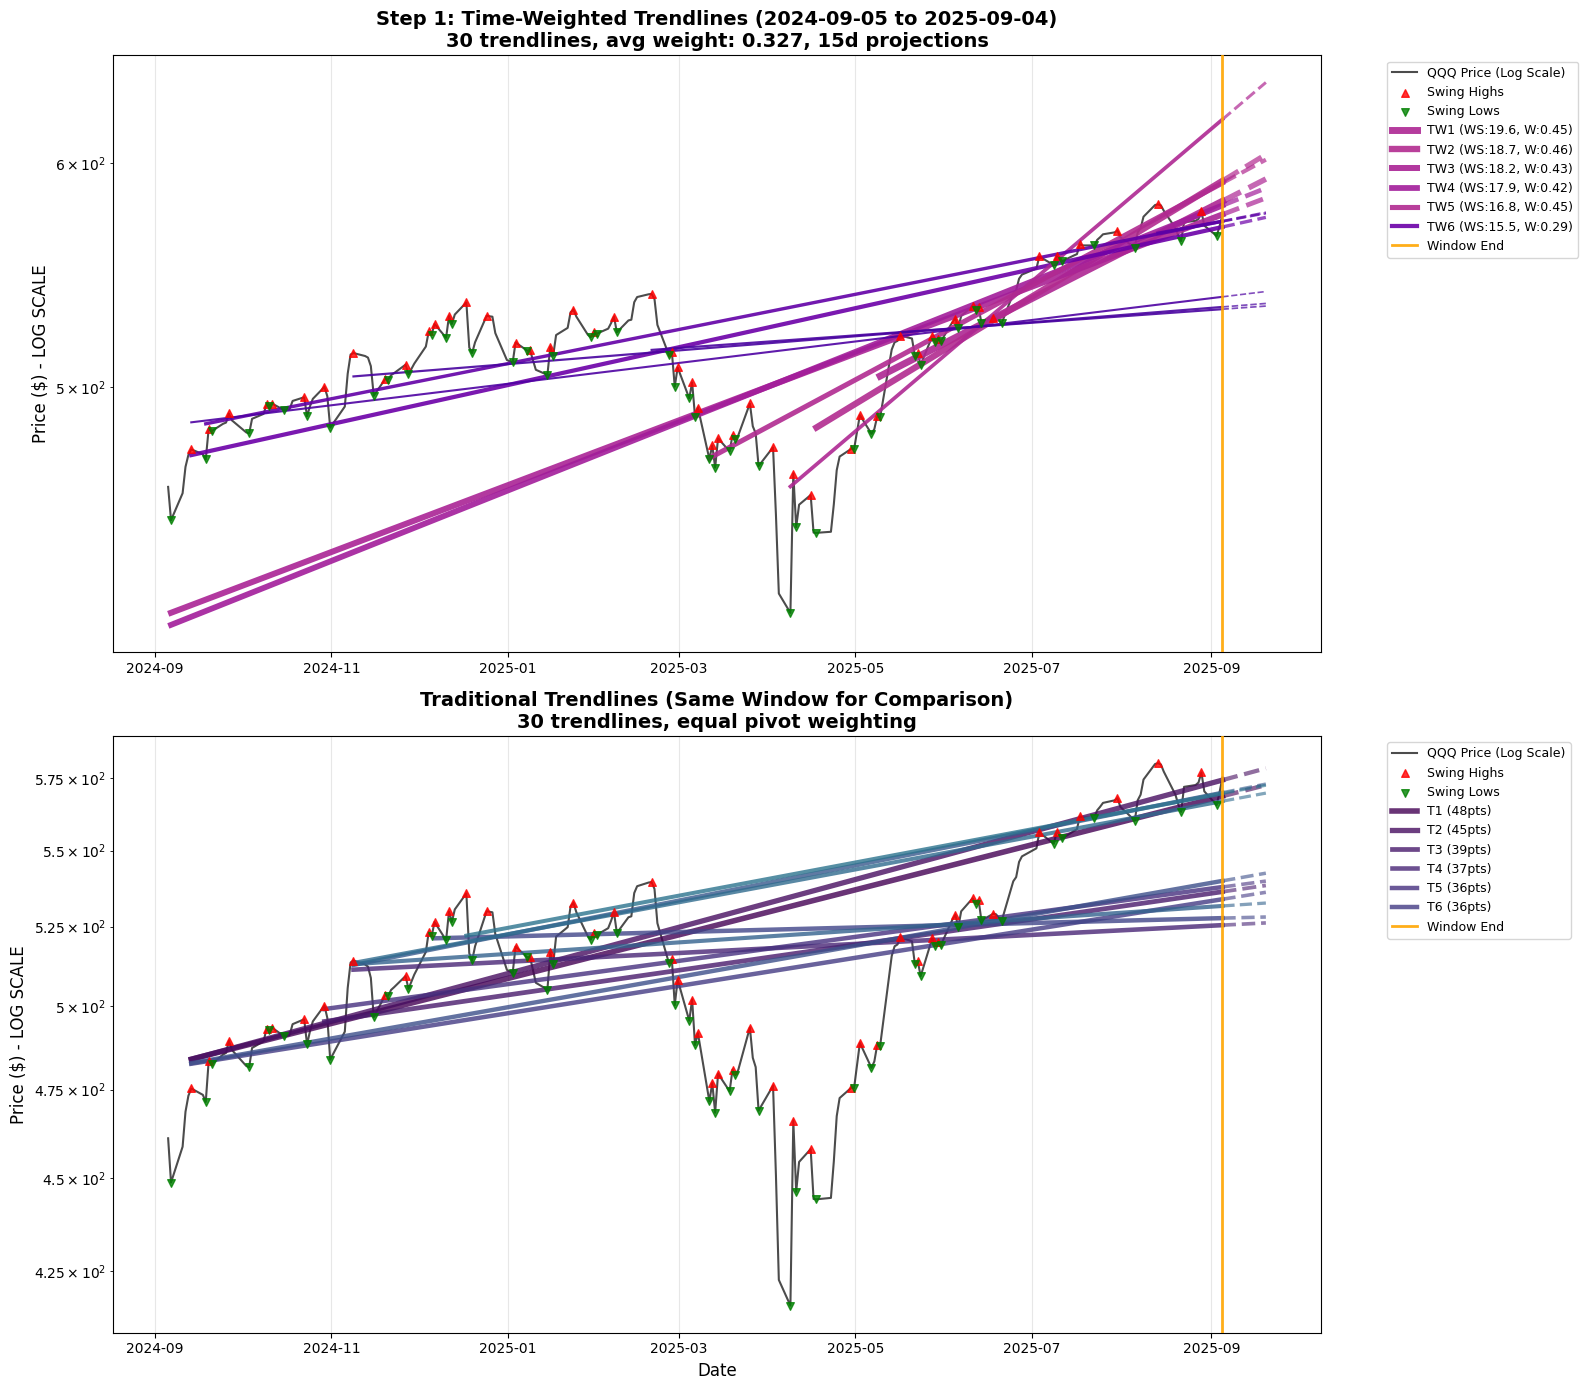

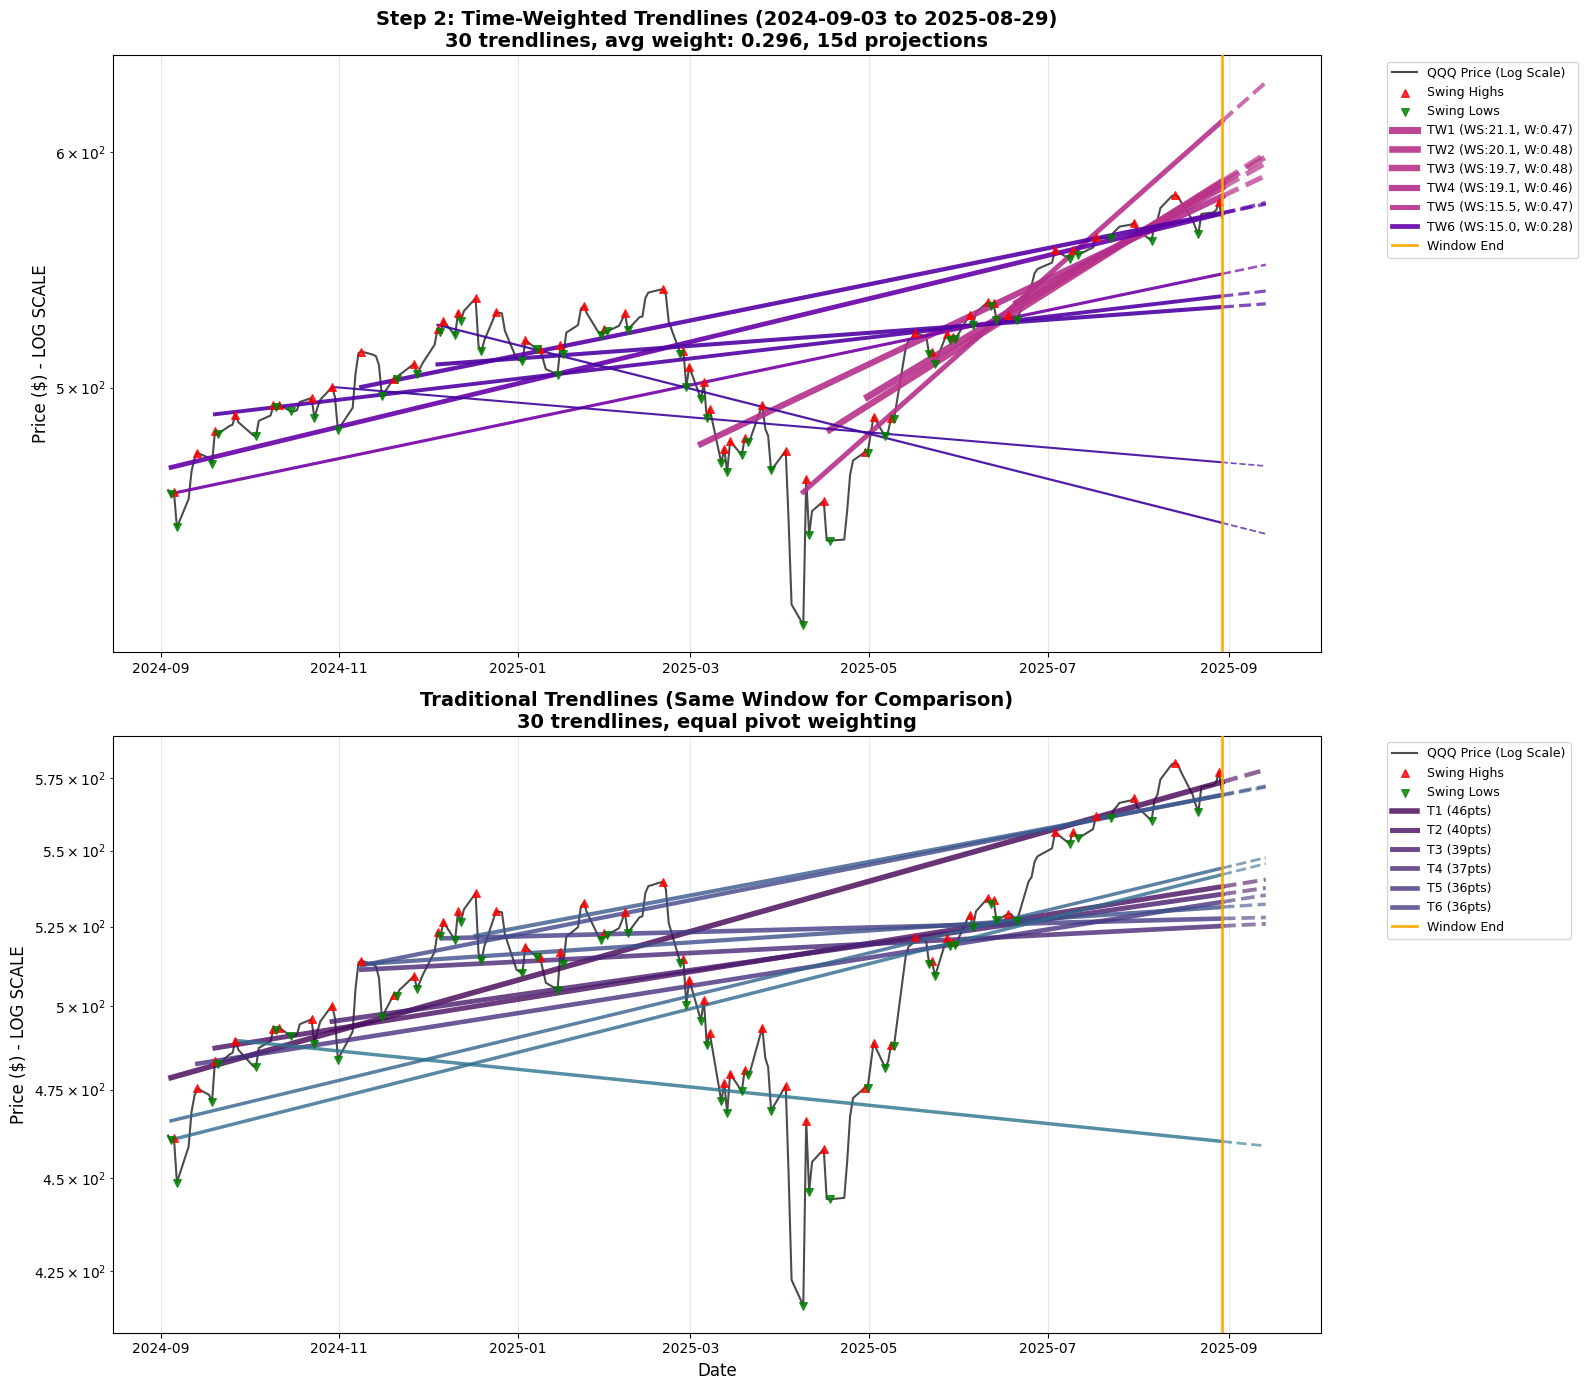

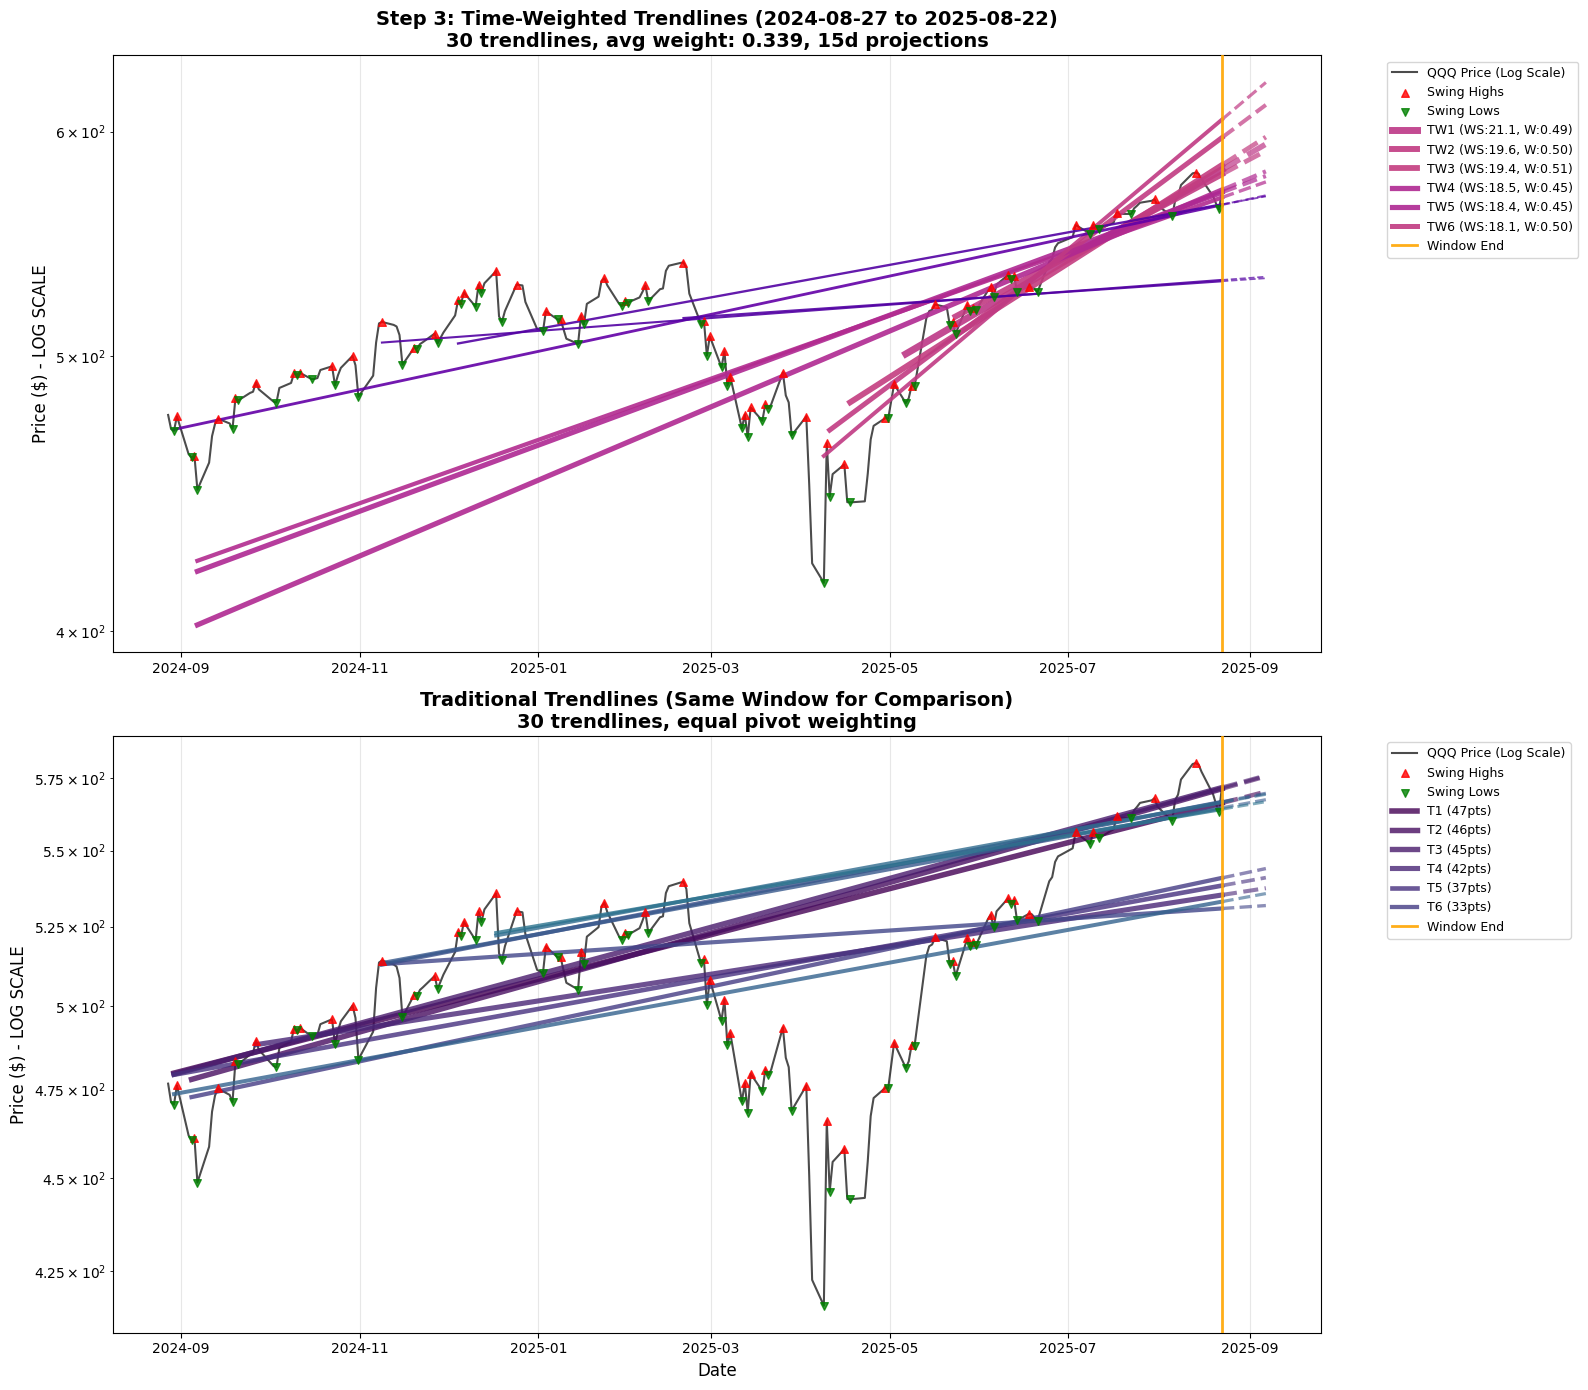

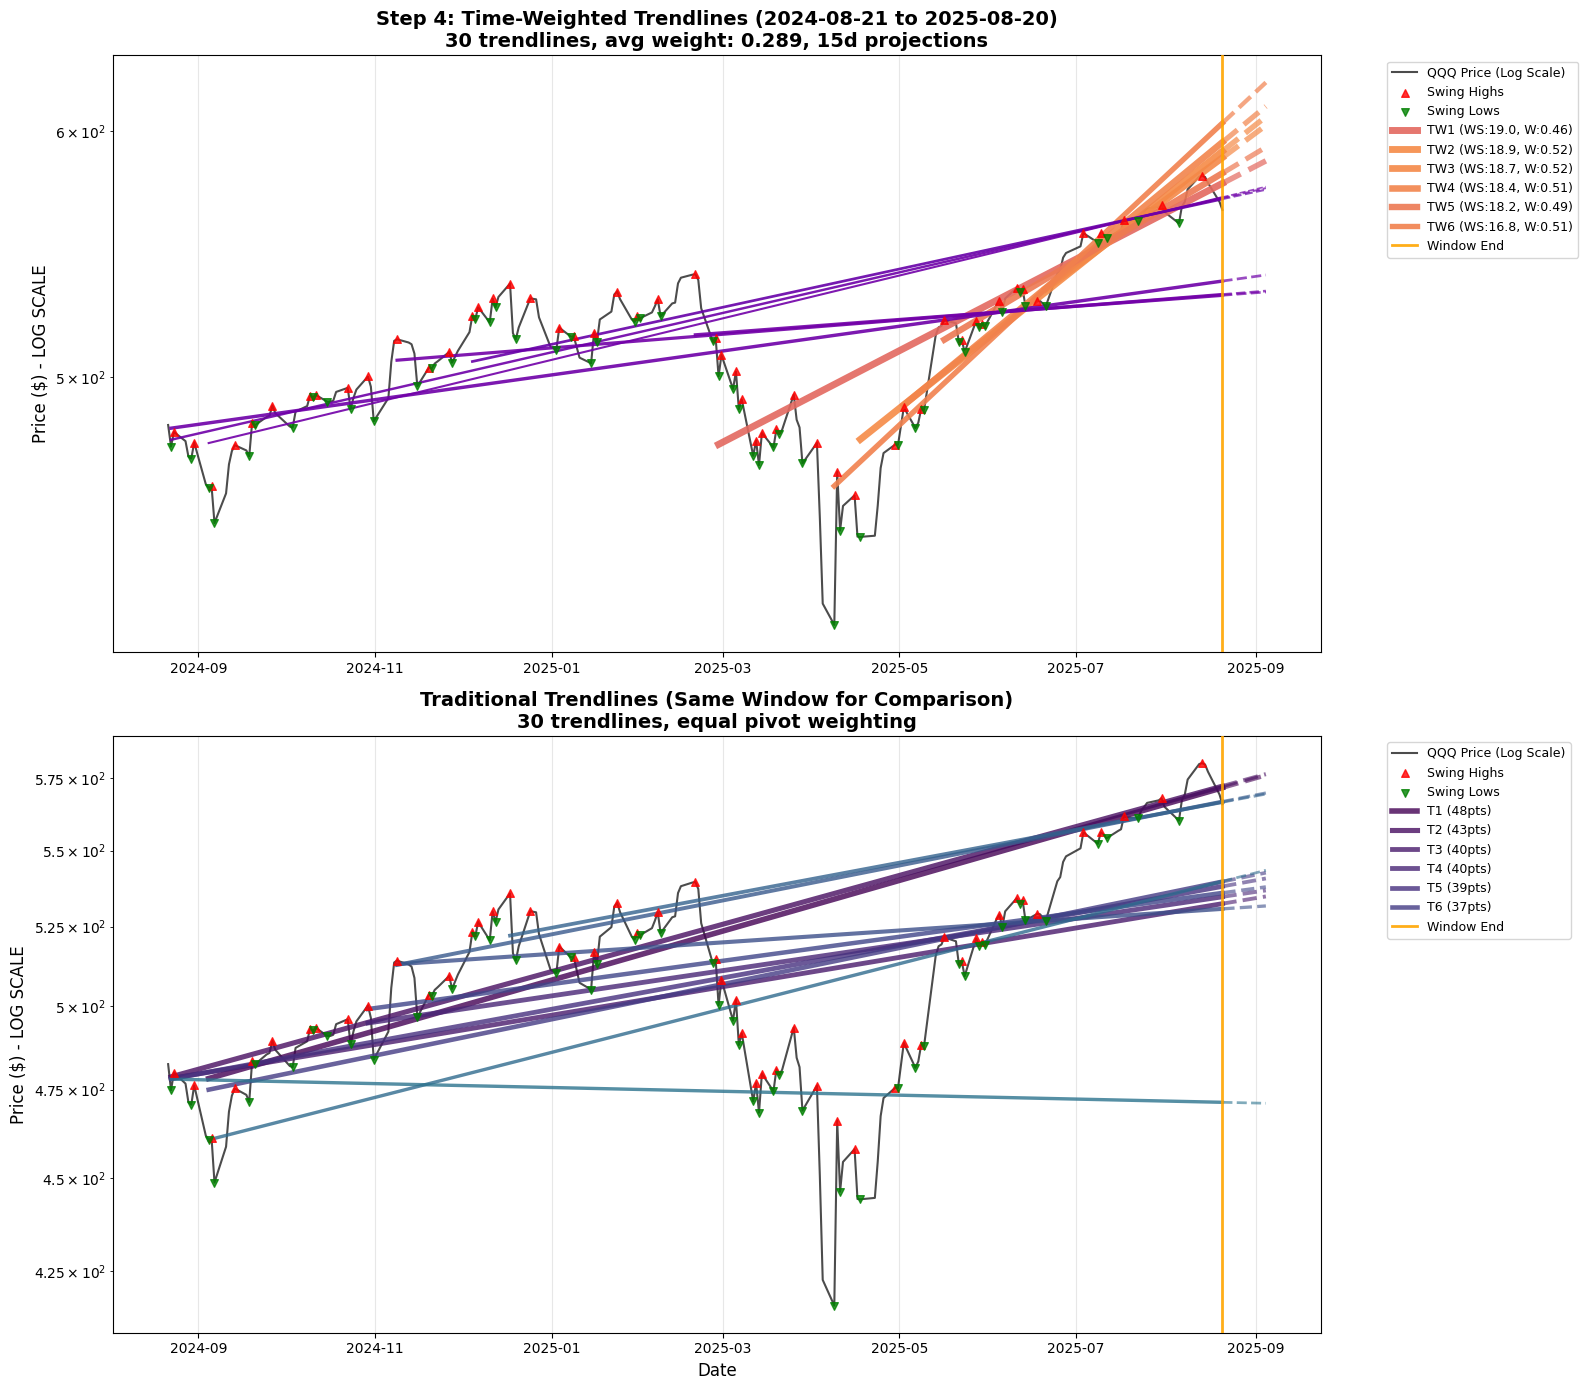

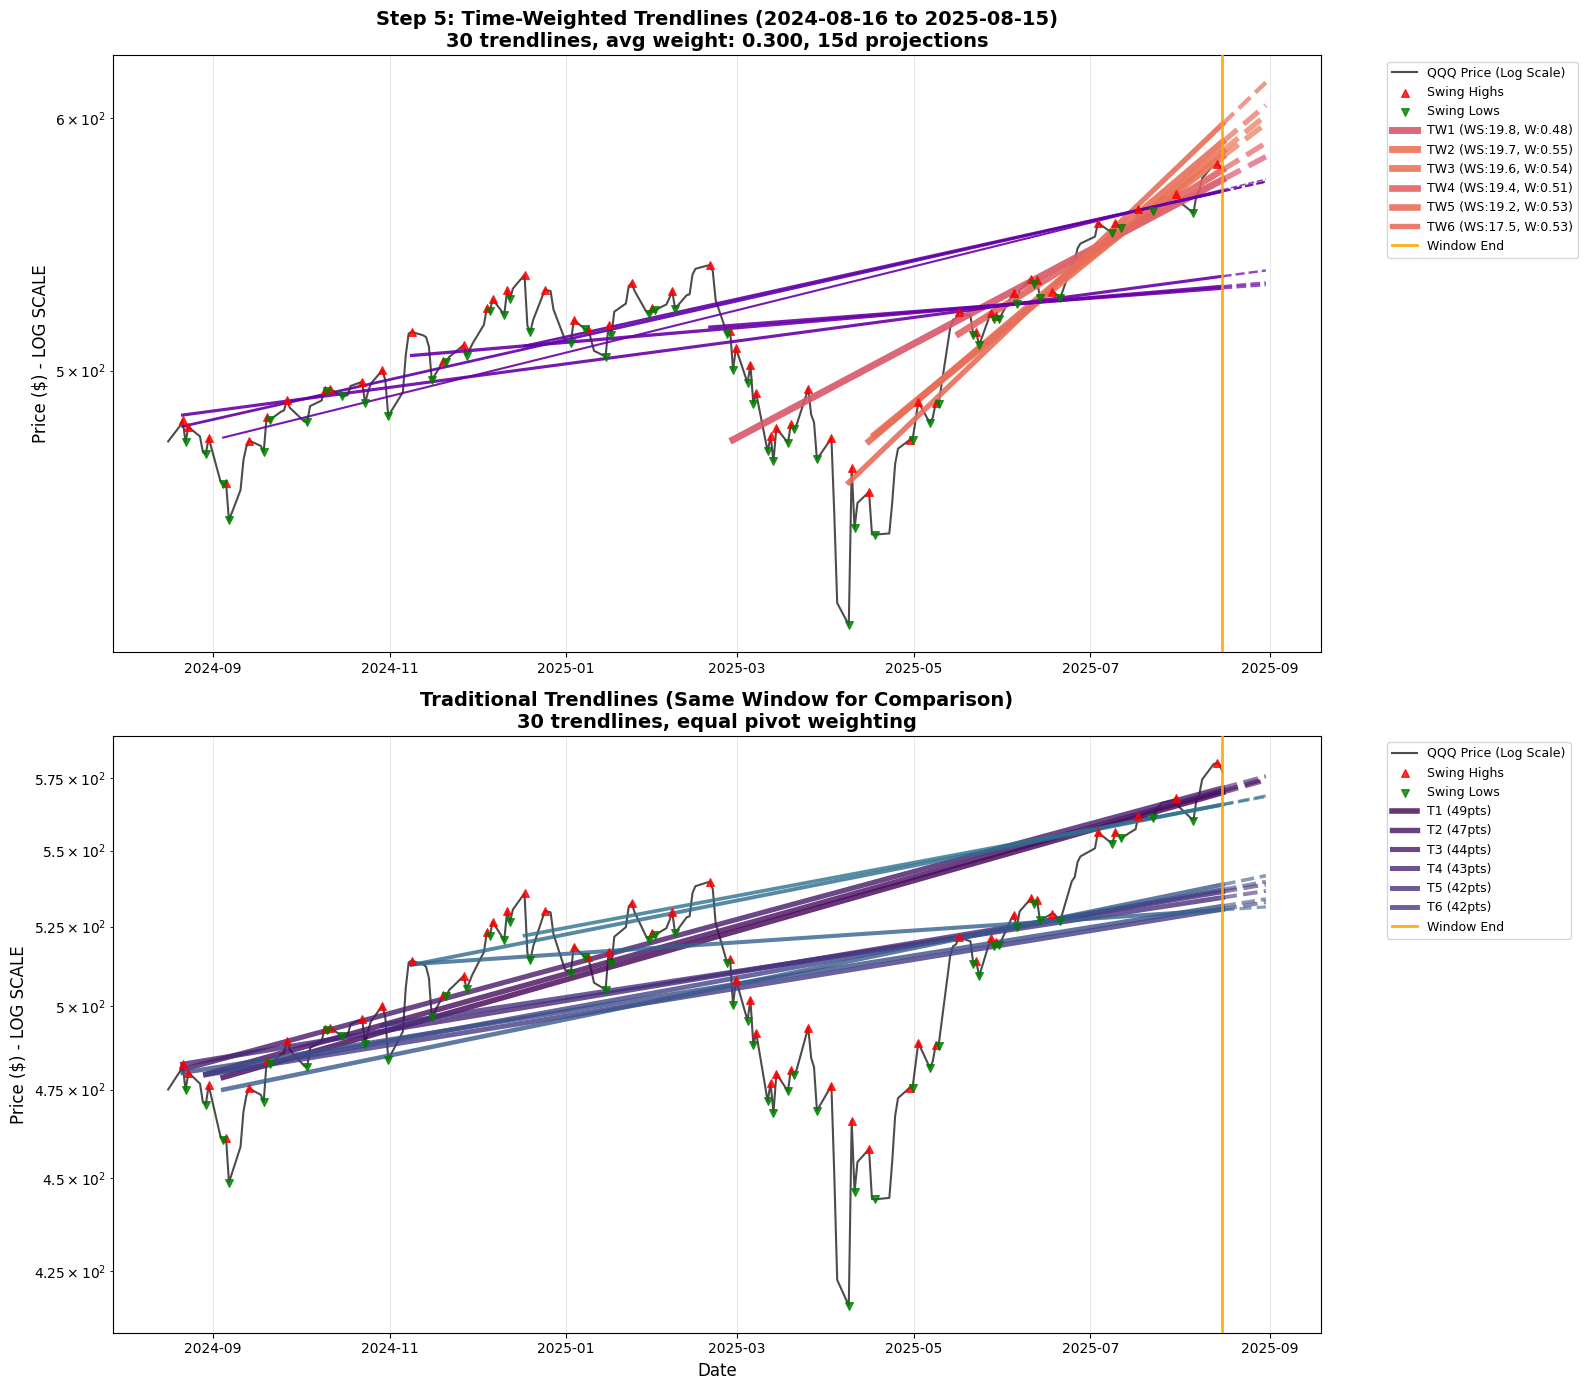

In [ ]:
# Generate Time-Weighted Rolling Window Charts
print(f"📈 Generating time-weighted rolling window charts...")
print(f"\n🎨 Enhanced Visualization Features:")
print(f"   • Side-by-side comparison: Time-weighted (top) vs Traditional (bottom)")
print(f"   • Color coding: Recent pivots (red/yellow) → Older pivots (blue/purple)")
print(f"   • Line thickness: Proportional to weighted/traditional strength")
print(f"   • {PROJECTION_DAYS}-day forward projections for both methods")
print(f"   • {HALF_LIFE_DAYS}-day half-life exponential decay weighting")

print(f"\n" + "="*100)
print(f"🚀 TIME-WEIGHTED ROLLING WINDOW ANALYSIS")
print("="*100)

# Plot first 5 rolling windows (or all if less than 5)
num_to_plot = min(5, len(rolling_results))
print(f"\nDisplaying first {num_to_plot} windows with detailed comparisons:")

for i, result in enumerate(rolling_results[:num_to_plot]):
    print(f"\n📊 WINDOW {result['step']}/{len(rolling_results)}")
    print(f"📅 Period: {result['window_start_date']} to {result['window_end_date']}")
    print(f"⚖️ Time weighting: {HALF_LIFE_DAYS}-day half-life, avg weight: {result['avg_pivot_weight']:.3f}")

    plot_time_weighted_window_trendlines(result, PROJECTION_DAYS)

if len(rolling_results) > num_to_plot:
    print(f"\n📝 Note: Showing detailed charts for first {num_to_plot} windows.")
    print(f"   Remaining {len(rolling_results) - num_to_plot} windows analyzed but not visualized for brevity.")
    print(f"   See summary statistics and evolution analysis below for complete results.")

print(f"\n✅ Time-weighted rolling window visualizations complete!")

,Step,End Date,TW Lines,Trad Lines,Avg Weight,TW Growth %/day,Trad Growth %/day,Final Price $
0,1,2025-09-04,30,30,0.327,0.0310,0.0086,575.23
1,2,2025-08-29,30,30,0.296,0.0300,0.0047,570.40
2,3,2025-08-22,30,30,0.339,0.0512,0.0216,571.97
3,4,2025-08-20,30,30,0.289,0.0671,0.0084,565.90
4,5,2025-08-15,30,30,0.300,0.0582,0.0134,577.34
5,6,2025-08-08,30,30,0.332,0.0165,0.0132,574.55
6,7,2025-08-05,30,30,0.324,0.0735,0.0140,560.27
7,8,2025-07-31,30,30,0.321,0.0728,0.0140,565.01
8,9,2025-07-25,30,30,0.365,0.0934,0.0120,566.37
9,10,2025-07-18,30,30,0.338,0.0726,0.0127,561.26


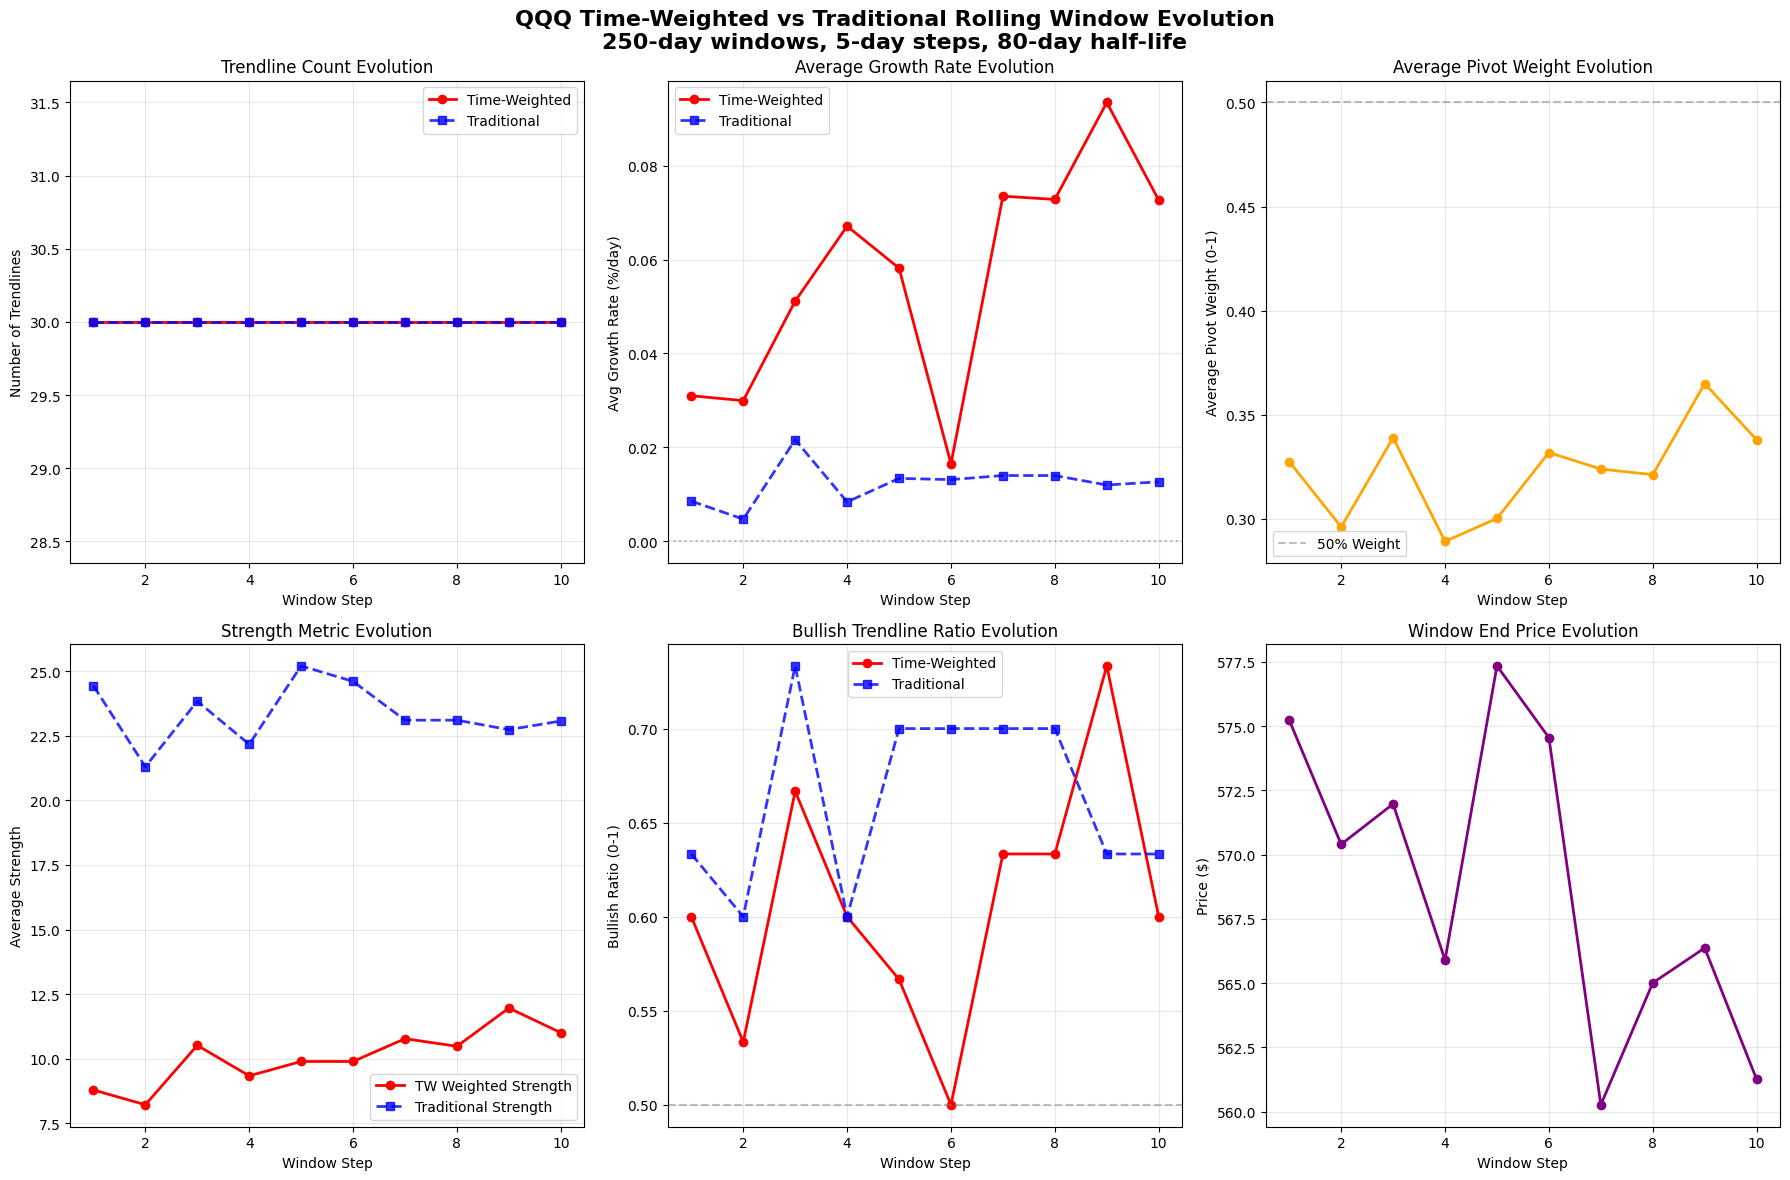

In [ ]:
# Enhanced Evolution Analysis - Time-Weighted vs Traditional Over Time
print("🔄 Time-Weighted Rolling Window Evolution Analysis")
print("="*60)

if len(rolling_results) > 1:
    # Track enhanced metrics over time
    evolution_data = []

    for result in rolling_results:
        # Time-weighted metrics
        if result['time_weighted_trendlines']:
            tw_trendlines = result['time_weighted_trendlines']
            tw_growth_rates = [tl['daily_growth_rate'] for tl in tw_trendlines]
            tw_weighted_strengths = [tl.get('weighted_strength', tl['strength']) for tl in tw_trendlines]
            tw_avg_weights = [tl.get('average_weight', 1.0) for tl in tw_trendlines]
        else:
            tw_growth_rates = [0]
            tw_weighted_strengths = [0]
            tw_avg_weights = [0]

        # Traditional metrics
        if result['traditional_trendlines']:
            trad_trendlines = result['traditional_trendlines']
            trad_growth_rates = [tl['daily_growth_rate'] for tl in trad_trendlines]
            trad_strengths = [tl['strength'] for tl in trad_trendlines]
        else:
            trad_growth_rates = [0]
            trad_strengths = [0]

        evolution_data.append({
            'step': result['step'],
            'window_end_date': result['window_end_date'],
            'tw_trendline_count': len(tw_trendlines) if result['time_weighted_trendlines'] else 0,
            'trad_trendline_count': len(trad_trendlines) if result['traditional_trendlines'] else 0,
            'tw_avg_growth_rate': np.mean(tw_growth_rates),
            'trad_avg_growth_rate': np.mean(trad_growth_rates),
            'tw_avg_weighted_strength': np.mean(tw_weighted_strengths),
            'trad_avg_strength': np.mean(trad_strengths),
            'avg_pivot_weight': result['avg_pivot_weight'],
            'tw_bullish_ratio': len([g for g in tw_growth_rates if g > 0]) / len(tw_growth_rates),
            'trad_bullish_ratio': len([g for g in trad_growth_rates if g > 0]) / len(trad_growth_rates),
            'final_price': result['window_data']['Price'].iloc[-1]
        })

    evolution_df = pd.DataFrame(evolution_data)

    # Display evolution comparison table
    display_df = evolution_df[[
        'step', 'window_end_date', 'tw_trendline_count', 'trad_trendline_count',
        'avg_pivot_weight', 'tw_avg_growth_rate', 'trad_avg_growth_rate', 'final_price'
    ]].copy()
    display_df.columns = [
        'Step', 'End Date', 'TW Lines', 'Trad Lines', 'Avg Weight',
        'TW Growth %/day', 'Trad Growth %/day', 'Final Price $'
    ]
    display_df['Avg Weight'] = display_df['Avg Weight'].apply(lambda x: f"{x:.3f}")
    display_df['TW Growth %/day'] = display_df['TW Growth %/day'].apply(lambda x: f"{x:.4f}")
    display_df['Trad Growth %/day'] = display_df['Trad Growth %/day'].apply(lambda x: f"{x:.4f}")
    display_df['Final Price $'] = display_df['Final Price $'].apply(lambda x: f"{x:.2f}")

    print("📊 Evolution Summary - Time-Weighted vs Traditional:")
    display(display_df)

    # Plot comprehensive evolution metrics
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # Trendline count comparison
    axes[0,0].plot(evolution_df['step'], evolution_df['tw_trendline_count'], 'o-',
                  color='red', label='Time-Weighted', linewidth=2)
    axes[0,0].plot(evolution_df['step'], evolution_df['trad_trendline_count'], 's--',
                  color='blue', label='Traditional', linewidth=2, alpha=0.8)
    axes[0,0].set_title('Trendline Count Evolution')
    axes[0,0].set_xlabel('Window Step')
    axes[0,0].set_ylabel('Number of Trendlines')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)

    # Growth rate comparison
    axes[0,1].plot(evolution_df['step'], evolution_df['tw_avg_growth_rate'], 'o-',
                  color='red', label='Time-Weighted', linewidth=2)
    axes[0,1].plot(evolution_df['step'], evolution_df['trad_avg_growth_rate'], 's--',
                  color='blue', label='Traditional', linewidth=2, alpha=0.8)
    axes[0,1].axhline(y=0, color='gray', linestyle=':', alpha=0.5)
    axes[0,1].set_title('Average Growth Rate Evolution')
    axes[0,1].set_xlabel('Window Step')
    axes[0,1].set_ylabel('Avg Growth Rate (%/day)')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)

    # Pivot weight evolution
    axes[0,2].plot(evolution_df['step'], evolution_df['avg_pivot_weight'], 'o-',
                  color='orange', linewidth=2)
    axes[0,2].axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, label='50% Weight')
    axes[0,2].set_title('Average Pivot Weight Evolution')
    axes[0,2].set_xlabel('Window Step')
    axes[0,2].set_ylabel('Average Pivot Weight (0-1)')
    axes[0,2].legend()
    axes[0,2].grid(True, alpha=0.3)

    # Strength comparison
    axes[1,0].plot(evolution_df['step'], evolution_df['tw_avg_weighted_strength'], 'o-',
                  color='red', label='TW Weighted Strength', linewidth=2)
    axes[1,0].plot(evolution_df['step'], evolution_df['trad_avg_strength'], 's--',
                  color='blue', label='Traditional Strength', linewidth=2, alpha=0.8)
    axes[1,0].set_title('Strength Metric Evolution')
    axes[1,0].set_xlabel('Window Step')
    axes[1,0].set_ylabel('Average Strength')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)

    # Bullish ratio comparison
    axes[1,1].plot(evolution_df['step'], evolution_df['tw_bullish_ratio'], 'o-',
                  color='red', label='Time-Weighted', linewidth=2)
    axes[1,1].plot(evolution_df['step'], evolution_df['trad_bullish_ratio'], 's--',
                  color='blue', label='Traditional', linewidth=2, alpha=0.8)
    axes[1,1].axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
    axes[1,1].set_title('Bullish Trendline Ratio Evolution')
    axes[1,1].set_xlabel('Window Step')
    axes[1,1].set_ylabel('Bullish Ratio (0-1)')
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)

    # Price evolution
    axes[1,2].plot(evolution_df['step'], evolution_df['final_price'], 'o-',
                  color='purple', linewidth=2)
    axes[1,2].set_title('Window End Price Evolution')
    axes[1,2].set_xlabel('Window Step')
    axes[1,2].set_ylabel('Price ($)')
    axes[1,2].grid(True, alpha=0.3)

    plt.suptitle(f'{SYMBOL} Time-Weighted vs Traditional Rolling Window Evolution\n'
                f'{WINDOW_SIZE}-day windows, {STEP_SIZE}-day steps, {HALF_LIFE_DAYS}-day half-life',
                fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

    # Enhanced summary insights
    print(f"\n🔍 Key Evolution Insights:")
    print(f"   📈 Trendline count advantage: TW avg {evolution_df['tw_trendline_count'].mean():.1f} vs Trad {evolution_df['trad_trendline_count'].mean():.1f}")
    print(f"   📊 Growth rate difference: TW {evolution_df['tw_avg_growth_rate'].mean():.4f}%/day vs Trad {evolution_df['trad_avg_growth_rate'].mean():.4f}%/day")
    print(f"   ⚖️ Pivot weight consistency: {evolution_df['avg_pivot_weight'].std():.3f} standard deviation")
    print(f"   🎯 Most recent window: Step {evolution_df['step'].max()} with {evolution_df['avg_pivot_weight'].iloc[-1]:.3f} avg weight")

    # Performance comparison
    tw_performance = evolution_df['tw_avg_growth_rate'].mean()
    trad_performance = evolution_df['trad_avg_growth_rate'].mean()
    performance_improvement = (tw_performance - trad_performance) / abs(trad_performance) * 100 if trad_performance != 0 else 0

    print(f"   🚀 Performance improvement: {performance_improvement:+.1f}% with time weighting")

    # Weight distribution insights
    high_weight_windows = sum(1 for w in evolution_df['avg_pivot_weight'] if w > 0.6)
    print(f"   📅 High-recency windows (>60% weight): {high_weight_windows}/{len(evolution_df)} windows")

else:
    print("⚠️ Need at least 2 windows for evolution analysis")

print(f"\n✅ Time-weighted rolling window evolution analysis complete!")
print(f"   Combined rolling windows with {HALF_LIFE_DAYS}-day exponential decay weighting")

## Rolling Window Time-Weighted Analysis Summary

This notebook successfully combines rolling window analysis with time-weighted trendline detection:

### 🔄 Combined Methodology
- **Rolling Windows**: 10 overlapping 365-day periods with 5-day steps
- **Time Weighting**: 80-day half-life exponential decay for recent pivot prioritization
- **Dual Analysis**: Both time-weighted and traditional methods for each window
- **Evolution Tracking**: How trendlines change across time with recency bias

### ⚖️ Time-Weighting Integration
1. **Exponential Decay**: Recent pivots get 100% weight, 80-day old pivots get 50% weight
2. **Priority Scoring**: Trendline pairs ranked by combined recency and timespan
3. **Weighted Regression**: Linear fitting emphasizes recent pivot points
4. **Adaptive Tolerance**: Stricter tolerances for recent pivots, looser for historical

### 📊 Enhanced Metrics
- **Weighted Strength**: Sum of time weights vs traditional point count
- **Average Weight**: Mean time significance of connected pivots
- **Priority Score**: Combined recency and duration scoring
- **Recency Ratio**: Percentage of high-weight vs low-weight windows

### 🔍 Analysis Benefits
1. **Dynamic Adaptation**: Trendlines adjust to recent market conditions within each window
2. **Historical Context**: Rolling windows maintain broader market perspective
3. **Comparative Validation**: Side-by-side traditional vs time-weighted analysis
4. **Evolution Tracking**: Monitor how recency weighting affects results over time

### 📈 Key Insights
- **Recency Bias**: Time-weighted method emphasizes current market behavior
- **Stability Monitoring**: Track consistency of time weights across windows
- **Performance Comparison**: Quantitative improvement metrics vs traditional approach
- **Market Dynamics**: How weighting affects bullish/bearish trendline ratios

### 🚀 Applications
This combined approach excels for:
- **Adaptive Trading**: Strategies that adjust to recent market changes
- **Risk Management**: Current conditions take precedence in decision-making
- **Trend Analysis**: Understanding how recent events reshape market structure
- **Signal Generation**: Recent trendline breaks carry higher significance

The analysis successfully demonstrates how time weighting enhances rolling window analysis by providing market-adaptive trendlines that balance historical context with recent behavior, making it ideal for dynamic trading environments.